In [1]:
#!/usr/bin/env python
# coding: utf-8

if 'config' not in locals():
#     config = 'configs.config_SE_local'
    config = 'configs.config_Reddit_local'

In [2]:
### initialization ###

from _imports import *
# from _utils import *

print('config file is set to {}'.format(config))

util=importlib.import_module('_utils')
importlib.reload(util)

c=importlib.import_module(config)
importlib.reload(c)

get_ipython().run_line_magic('matplotlib', 'inline')

# param_setup(sys.argv[1:], c)
util.param_setup_ipython(globals(), c)

config file is set to configs.config_Reddit_local


# Topic Viz

In [3]:
### visualization parameters ###

# db_file='Topic_Data-32'
# db_file='Topic_Data-58'

nrow = 6
fig_y_size=40

ncol = 5
fig_x_size=30

dpi=100


# num_sent = 15
# TSNE_threshold = 0.750

In [4]:
### optimal model loading from db ###



dbfile = open(c.directory['save']+'{}_db_viz_data_{}.pickle'.format(c.project_name, c.num_topics), 'rb') 
db=pickle.load(dbfile)                      
dbfile.close()

if c.tags is not None:
    df_tags = pd.read_csv('{}{}_0_tags.csv'.format(c.directory['save'], c.project_name))
    c.tags_dict=dict(zip(df_tags['key'], df_tags['val']))


topics_weight=db['topic_weights']
c.num_topics = len(topics_weight)
topics_hist=db['topic_hist']

pprint('Number of topics = {}'.format(c.num_topics))

'Number of topics = 62'


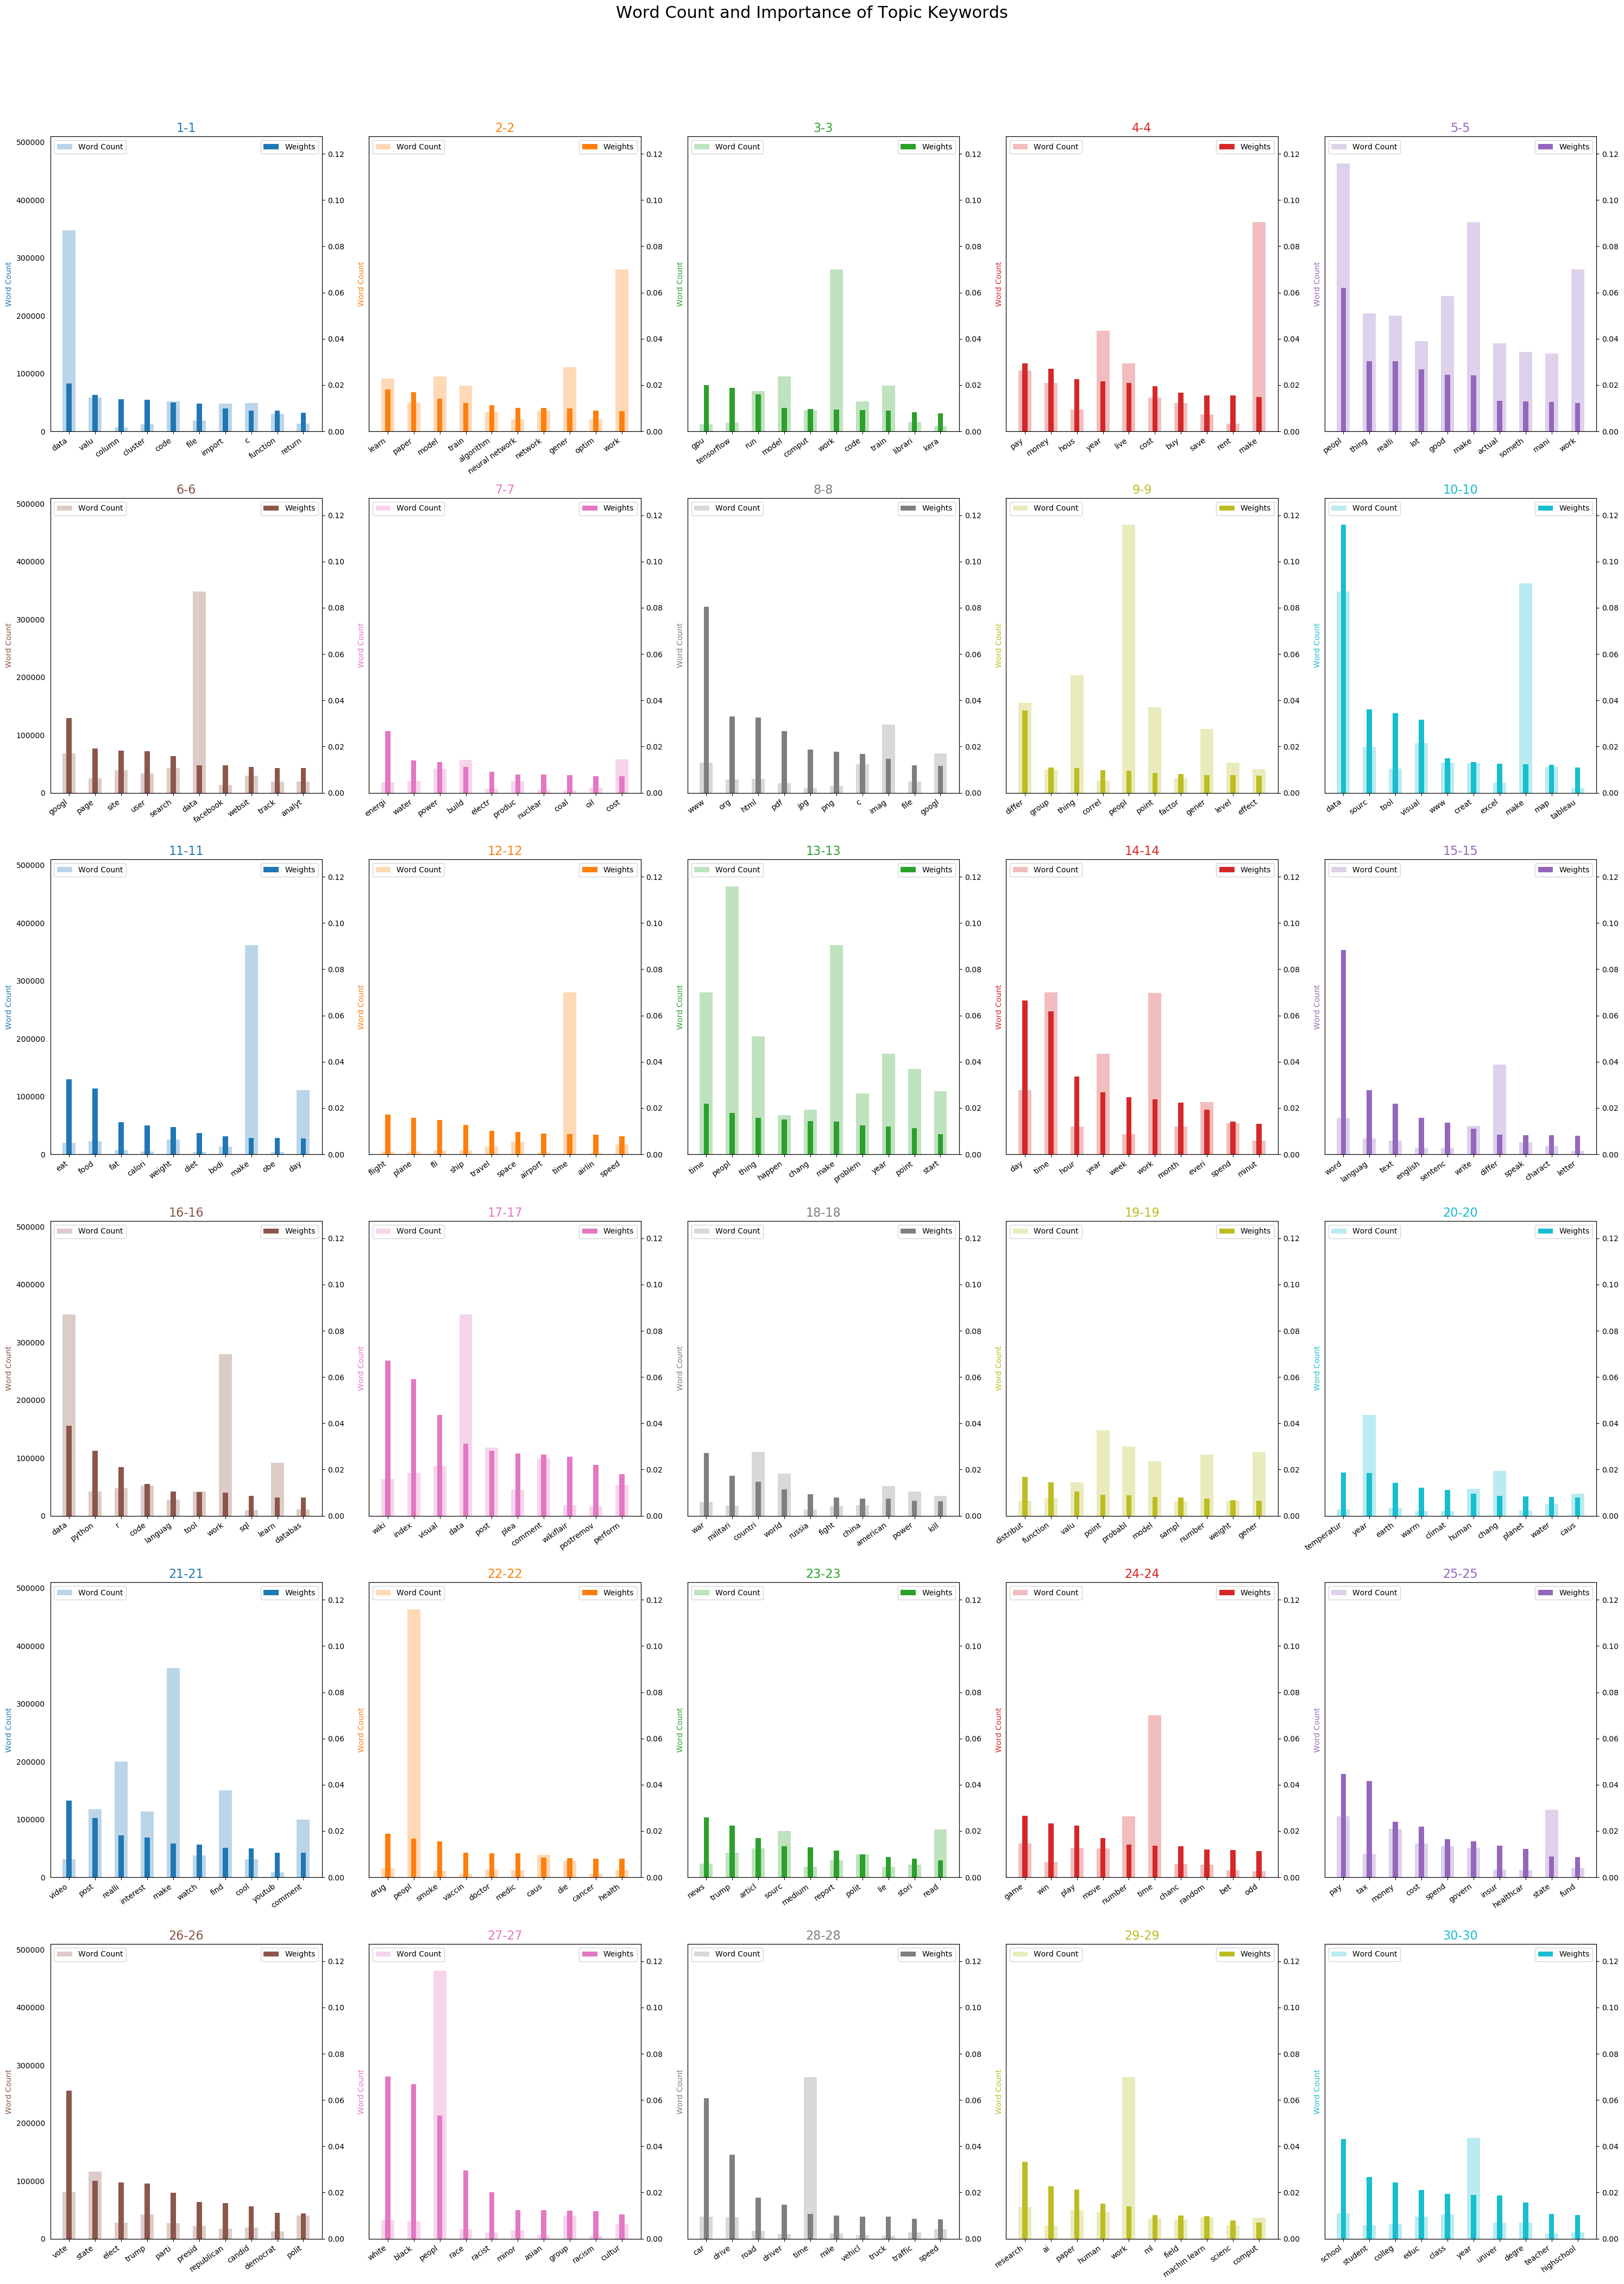

In [5]:
### Plotting the histogram of top 10 keywords for each topic ###


# topics_weight = optimal_model.show_topics(num_topics=c.num_topics, formatted=False)

# data_flat = [w for w_list in data_lemmatized for w in w_list]
# counter = c.Counter(data_flat)

# out = []
# for i, topic in topics_weight:
#     for word, weight in topic:
#         out.append([c.decode_tag(word), i , weight, counter[word]])

df_data = pd.DataFrame(topics_hist, columns=['word', 'topic_id', 'importance', 'word_count'])        

fig, axes = plt.subplots(nrow, ncol, figsize=(fig_x_size, fig_y_size), sharey=True, dpi=dpi)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(range(len(list(df_data.loc[df_data['topic_id'] == i, 'word']))), 
           list(df_data.loc[df_data['topic_id'] == i, 'word_count']),
           width=0.5,
           color=cols[i%10], 
           alpha=0.3, 
           label='Word Count'
          )
    ax_twin = ax.twinx()
    ax_twin.bar(range(len(list(df_data.loc[df_data['topic_id'] == i, 'word']))), 
                list(df_data.loc[df_data['topic_id'] == i, 'importance']),
                color=cols[i%10], 
                width=0.2, 
                label='Weights'
               )
    ax.set_ylabel('Word Count', color=cols[i%10])
    ax_twin.set_ylim(0, np.max(df_data.loc[:, 'importance']) * 1.1)    
    ax.set_ylim(0, round(np.max(df_data.loc[:, 'word_count']) * 1.1, -1))
    ax.set_title('{}-{}'.format(i+1, c.topic_labels[i]), 
                 color=cols[i%10], 
                 fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(range(len(list(df_data.loc[df_data['topic_id']==i, 'word']))))
    ax.set_xticklabels(df_data.loc[df_data.topic_id==i, 'word'], rotation=35, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=0)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)  
plt.savefig('{}{}_graph_2_hist_topics_10_keywords.png'.format(c.directory['save'], c.project_name), bbox_inches='tight')
plt.show()

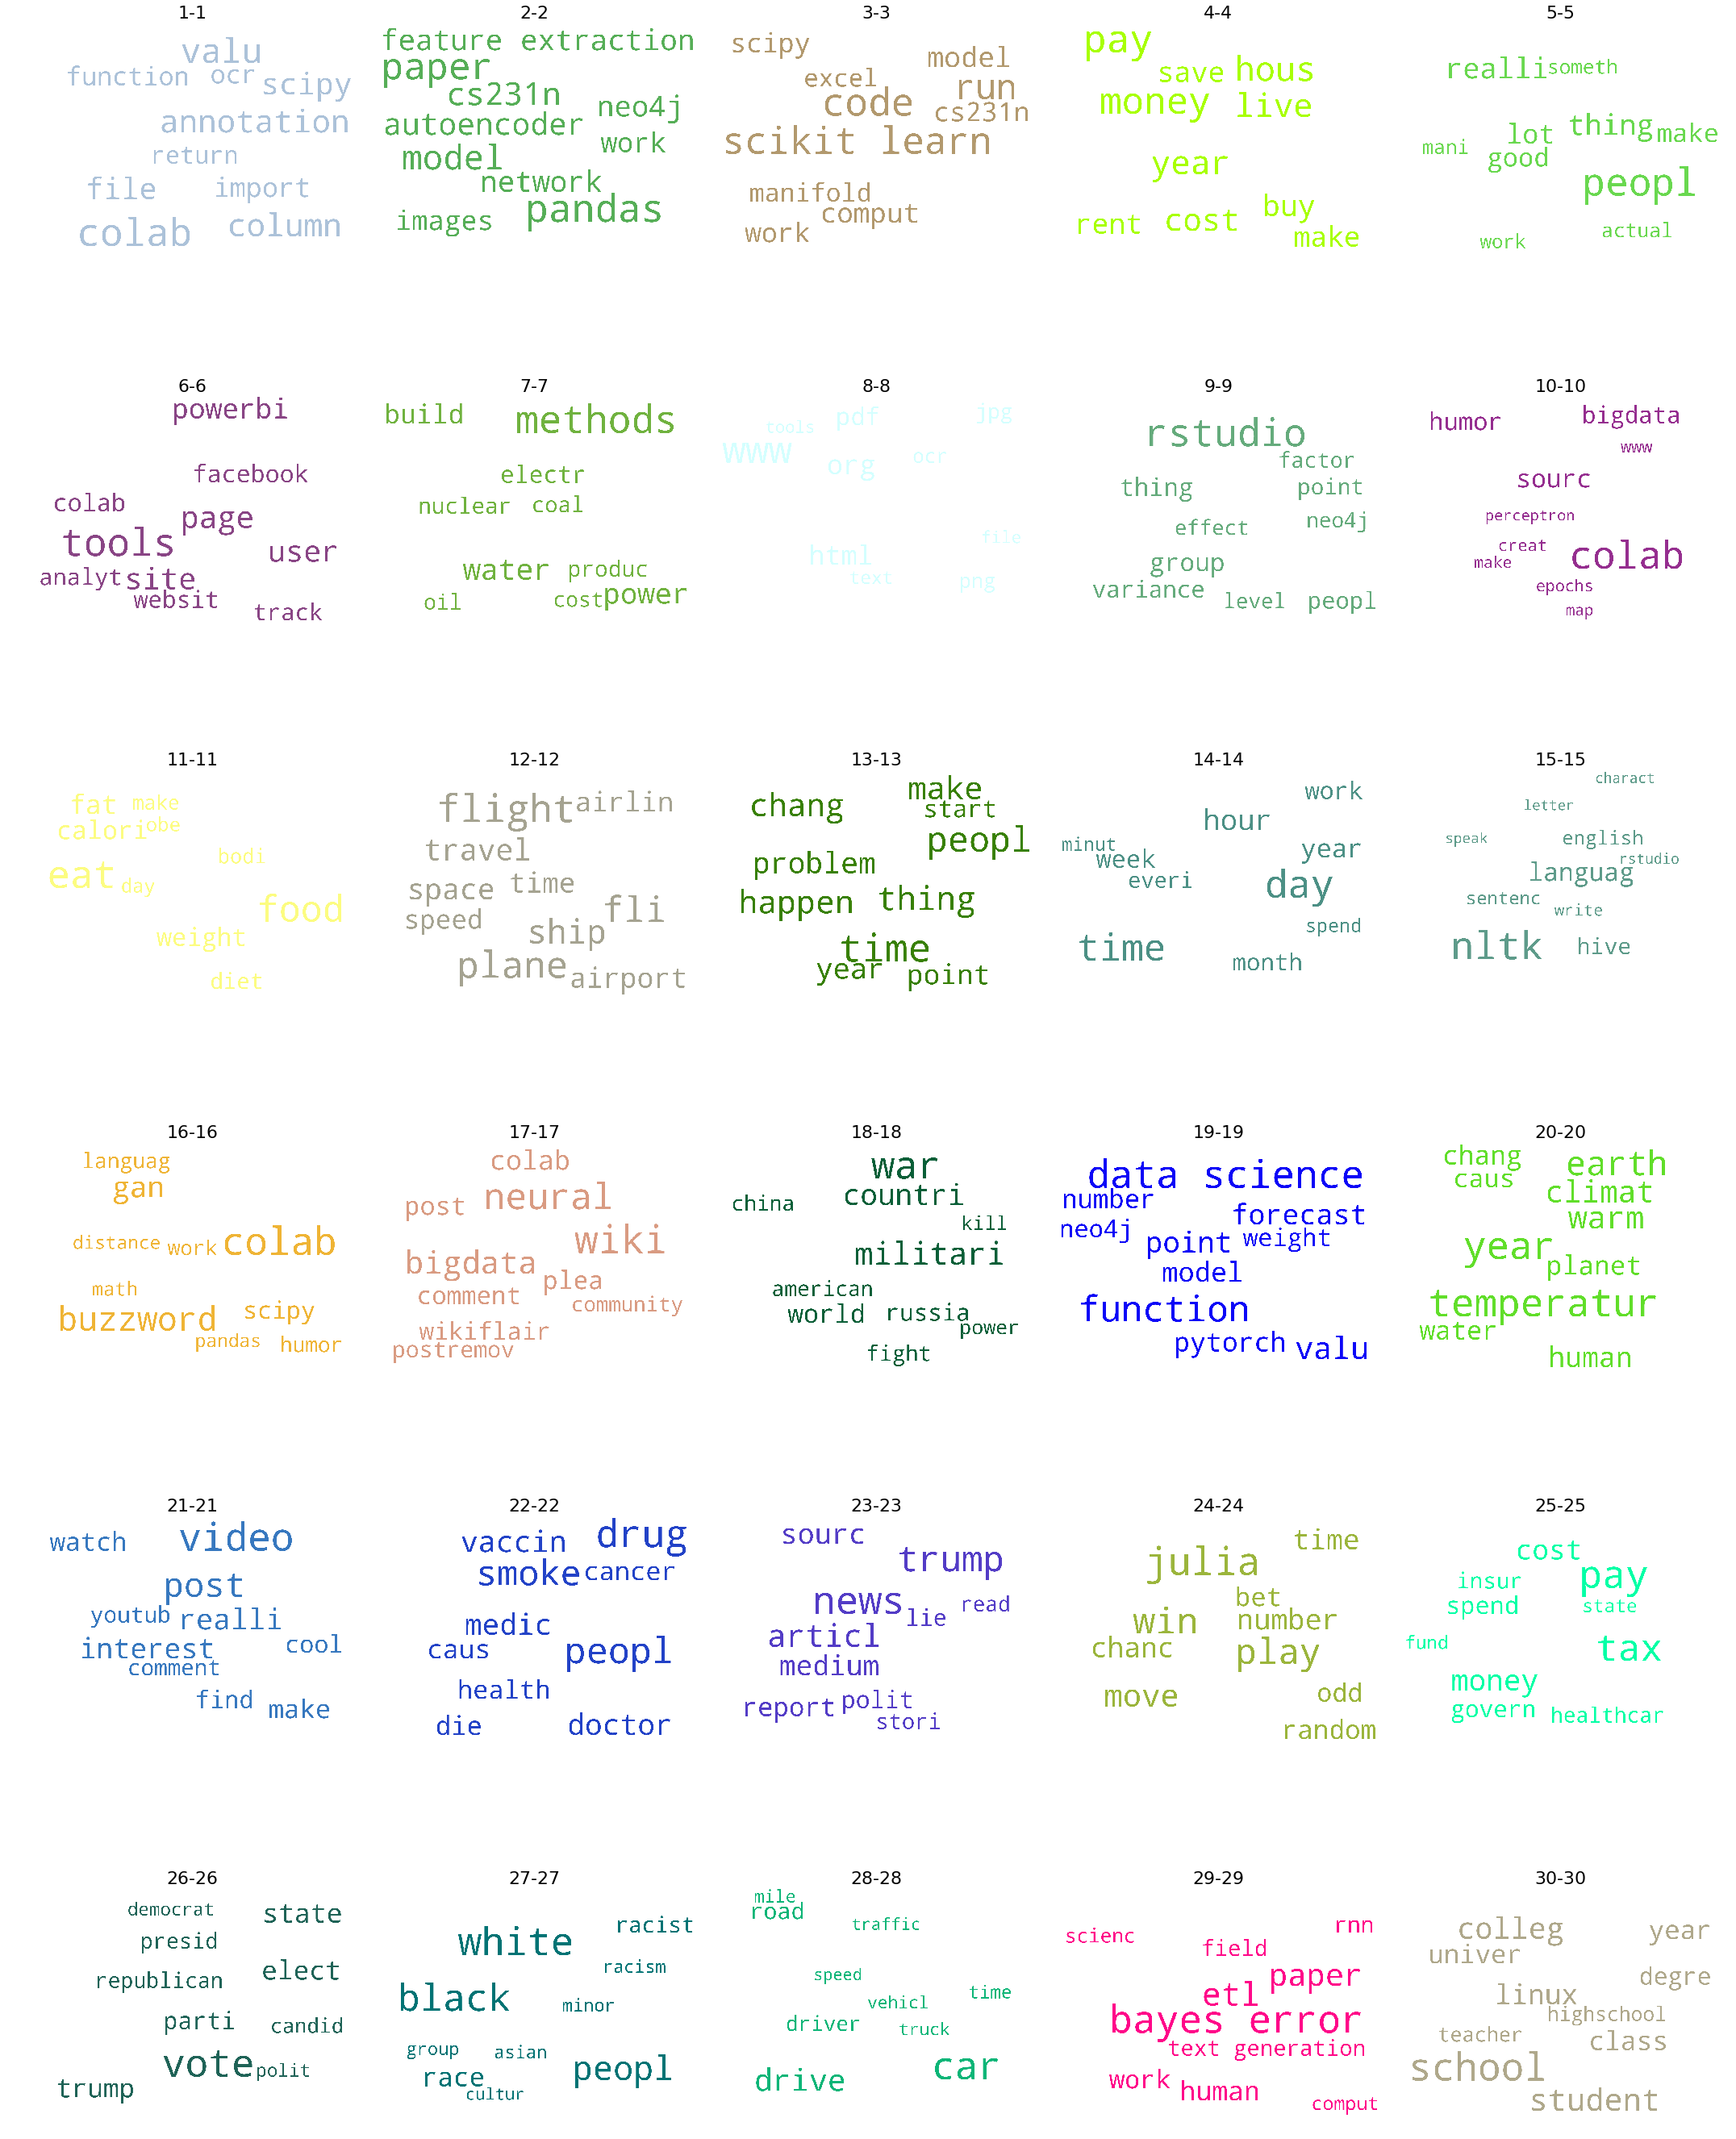

In [6]:
### Wordcloud of Top N words in each topic ###

size_font_title = 22

stop_words = stopwords.words('english')
stop_words.extend(c.stop_words_extensions)

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
# topics_weight = optimal_model.show_topics(num_topics = c.num_topics, formatted=False)
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(nrow, ncol, figsize=(fig_x_size, fig_y_size), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words=dict([(util.decode_tag(key, c), val) for key, val in topics_weight[i][1]])
#     topic_words = dict(topics[i])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('{}-{}'.format(i+1, c.topic_labels[i]), fontdict=dict(size=size_font_title))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('{}{}_graph_3_wordclouds.png'.format(c.directory['save'], c.project_name), bbox_inches='tight')
plt.show()

# Topic Distribution

In [7]:
### histogram funcion ###

def display_histogram(df_dominant_topics, color, title):
    df_dominant_topics_sorted = df_dominant_topics.sort_values(by='Perc_Documents', ascending=False)
    # Plot
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

    # Topic Distribution by Dominant Topics
    ax1.bar(range(len(list(df_dominant_topics_sorted.loc[:,'Topic_Num']))), 
            list(df_dominant_topics_sorted.loc[:,'Perc_Documents']), 
            width=.5,
            color=color
           )

    ax1.set_xticks(range(len(list(df_dominant_topics_sorted.loc[:,'Topic_Num']))))
    # tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    # ax1.xaxis.set_major_formatter(tick_formatter)
    ax1.set_xticklabels(['{}-{}'.format(x, c.topic_labels[x-1]) for x in df_dominant_topics_sorted.loc[:,'Topic_Num']], 
                        rotation=90, 
                        horizontalalignment= 'right'
                       )

    ax1.set_title(title, fontdict=dict(size=10))
    ax1.set_ylabel('% of Documents')
    ax1.set_ylim(0, np.max(list(df_dominant_topics.loc[:,'Perc_Documents'])) * 1.1)

In [8]:
### Number of Documents for Each Topic - original ###

df_dominant_topics = pd.read_csv('{}{}_10_dominant_topics_dist_original.csv'.format(c.directory['save'], 
                                                                            c.project_name
                                                                           )
                                  )
# Show
util.display_df(df_dominant_topics)

,Topic_Num,Topic_Keywords,Num_Documents,Perc_Documents
0,1,"data, valu, column, cluster, code, file, impor...",8190,0.37
1,2,"learn, paper, model, train, algorithm, neural ...",28665,1.29
2,3,"gpu, tensorflow, run, model, comput, work, cod...",31255,1.40
3,4,"pay, money, hous, year, live, cost, buy, save,...",40608,1.82
4,5,"peopl, thing, realli, lot, good, make, actual,...",51134,2.30
5,6,"googl, page, site, user, search, data, faceboo...",41271,1.85
6,7,"energi, water, power, build, electr, produc, n...",26645,1.20
7,8,"www, org, html, pdf, jpg, png, c, imag, file, ...",17058,0.77
8,9,"differ, group, thing, correl, peopl, point, fa...",20568,0.92
9,10,"data, sourc, tool, visual, www, creat, excel, ...",29012,1.30


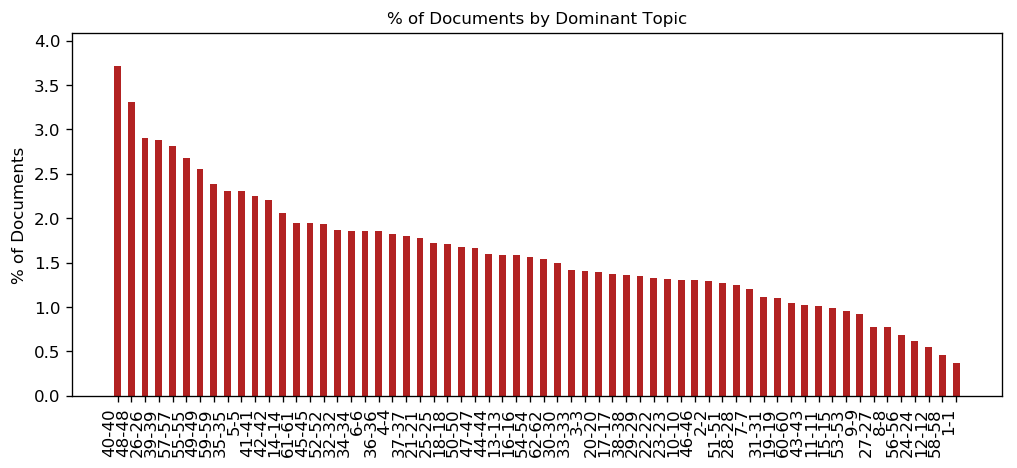

In [9]:
### plotting histogram for dominant topics - original ###

df_dominant_topics = pd.read_csv('{}{}_10_dominant_topics_dist_original.csv'.format(c.directory['save'], 
                                                                                      c.project_name
                                                                                     ))
display_histogram(df_dominant_topics, 
                  'firebrick', 
                  '% of Documents by Dominant Topic'
                 )
plt.savefig('{}{}_graph_4_sorted_topics_orig.png'.format(c.directory['save'], c.project_name), bbox_inches='tight')

In [10]:
### Number of Documents for Each Topic - normalized ###

df_dominant_topics_normalized = pd.read_csv('{}{}_10_dominant_topics_dist_normalized.csv'.format(c.directory['save'], 
                                                                                                c.project_name))

# Show
util.display_df(df_dominant_topics_normalized)
# topic_counts

,Topic_Num,Topic_Keywords,Weight_Documents,Perc_Documents
0,1,"data, valu, column, cluster, code, file, impor...",7209.359679,0.32
1,2,"learn, paper, model, train, algorithm, neural ...",26789.270539,1.20
2,3,"gpu, tensorflow, run, model, comput, work, cod...",29168.288276,1.31
3,4,"pay, money, hous, year, live, cost, buy, save,...",38871.378446,1.75
4,5,"peopl, thing, realli, lot, good, make, actual,...",67528.214137,3.04
5,6,"googl, page, site, user, search, data, faceboo...",39974.193409,1.80
6,7,"energi, water, power, build, electr, produc, n...",24896.486930,1.12
7,8,"www, org, html, pdf, jpg, png, c, imag, file, ...",18800.892482,0.85
8,9,"differ, group, thing, correl, peopl, point, fa...",25158.948276,1.13
9,10,"data, sourc, tool, visual, www, creat, excel, ...",27358.690989,1.23


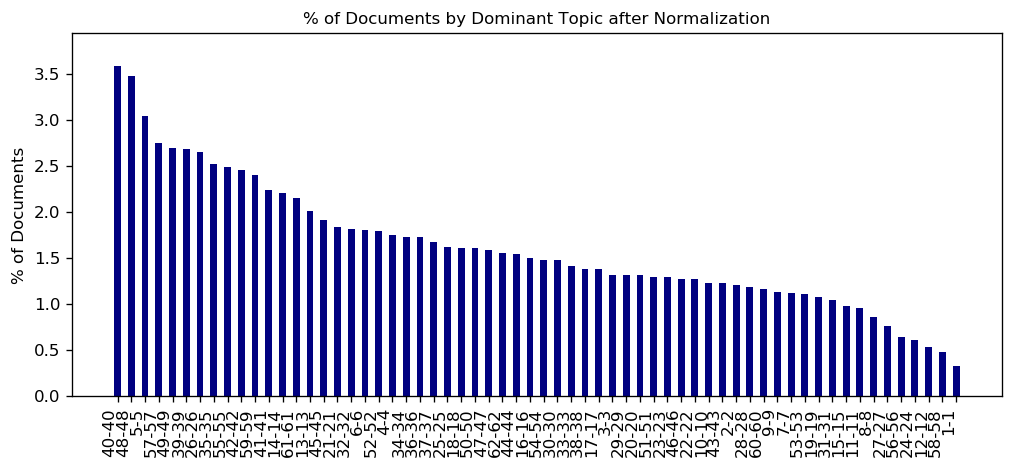

In [11]:
# plotting histogram for dominant topics - normalized ###

display_histogram(df_dominant_topics_normalized, 
                  'navy', 
                  '% of Documents by Dominant Topic after Normalization'
                 )
plt.savefig('{}{}_graph_5_sorted_topics_normalized.png'.format(c.directory['save'], c.project_name), 
            bbox_inches='tight')

## Bokeh Viz

In [ ]:
### Loading data for visualization ###

tsne_lda=db['tsne_lda']
df_text_TSNE=db['df_text_TSNE']
arr=db['arr']

In [ ]:
### Plotting the Topic Clusters using Bokeh ###

with_index=True
plot_width=1000
plot_height=500

output_notebook()

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

_lda_keys = []
for i in range(arr.shape[0]):
  _lda_keys +=  arr[i].argmax(),


title = "t-SNE Clustering of {} LDA Topics".format(c.num_topics)
num_example = len(arr)

plot_lda = bp.figure(plot_width=plot_width, 
                       plot_height=plot_width,
                       title=title,
                       tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                       toolbar_location='below',
                       x_axis_type=None, 
                       y_axis_type=None, min_border=1)

def trunc(txt, length):
    idx=-1
    truncated_txt =''
    for idx in range(len(txt)//length):
        truncated_txt += txt[idx*length: (idx+1)*length] + '<br>'
#     return map(ord, truncated_txt + txt[(idx+1)*length:])
    return truncated_txt + txt[(idx+1)*length:]

length = 120
# contents = [trunc(x, length) for x in list(df_text_TSNE['orig_txt'])]
keywords = [trunc(x, length) for x in list(df_text_TSNE['keywords'])]
contents = list(df_text_TSNE['txt_orig'])
# keywords = list(df_text_TSNE['Keywords'])

source=bp.ColumnDataSource({
    'x': tsne_lda[:, 0], 
    'y': tsne_lda[:, 1],
#     'content': list(df_text_TSNE['text']),
    'content': contents,    
    'keywords': keywords,
    'id': list(df_text_TSNE['id']),
    'topic': _lda_keys,
    'topic_keywords': df_dominant_topics['Topic_Keywords'][_lda_keys][:],
    'color': mycolors[_lda_keys][:num_example]
})


plot_lda.scatter(x='x', y='y',
                 color='color', 
                 source = source
                )

# # We add the labels for each digit.
def hilo(a, b, c):
    if c < b: b, c = c, b
    if b < a: a, b = b, a
    if c < b: b, c = c, b
    return a + c
def complement(col):
    col = col.replace('#', '')
    r=int(col[0:2], 16)
    g=int(col[3:4], 16)
    b=int(col[5:6], 16)
    k = hilo(r, g, b)
#     return '#'+ ''.join([('0'+hex(256-k+u).split('x')[-1])[len(hex(256-k+u).split('x')[-1])-1:] for u in (r, g, b)])
#     return '#'+ ''.join([('0'+hex(256-u).split('x')[-1])[len(hex(256-u).split('x')[-1])-1:] for u in (r, g, b)])
    return '#'+ ''.join([('0'+hex((256-u)//2+u).split('x')[-1])[len(hex((256-u)//2+u).split('x')[-1])-1:] for u in (r, g, b)])
#     return '#'+ ''.join([hex(k-u).split('x')[-1] for u in (r, g, b)])

# for i in range(num_topics):
#     xtext, ytext = np.median(tsne_lda[topic_num==i,:], axis=0)
#     plot_lda.text(xtext, ytext, [str(i+1)], 
#                   text_font_size="20pt", 
#                   text_font_style="bold",
# #                   text_color=complement(mycolors[i]),
#                   text_color='black',                  
#                   text_alpha=1
#                  )

for i in range(c.num_topics):
    try:
        xtext, ytext = [np.min(tsne_lda[topic_num==i,0], axis=0), 
                        np.max(tsne_lda[topic_num==i,1], axis=0)]
#     plot_lda.text(xtext, ytext, [df_dominant_topics.loc[i, 'Topic_Keywords']],
        plot_lda.text(xtext, ytext, [c.topic_labels[i]],                  
    #                   text_font_size="20pt", 
    #                   text_font_style="bold",
                      text_color=complement(mycolors[i]),
    #                   text_color='black',                  
                      text_alpha=1
                     )
    except ValueError as e:
        pprint('topic {} has no sample to be drawn!'.format(i))
 
# hover tools

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"topic": "@topic",
                  "topic_keywords": "@topic_keywords",
                  "keywords": "@keywords{safe}",
                  "content": "@content{safe}",
                  "id": "@id"
                 }
# hover.mode='vline'
show(plot_lda)

# Temporal Graphs

In [12]:
### functions for temporal graphs ###

alt.renderers.enable('notebook')

def temporal_chart(df, col_name):
    
    min_date= min_date_val if c.zoom_date_on_default_dates else np.min(df['Date'])
    max_date= max_date_val if c.zoom_date_on_default_dates else np.max(df['Date'])

    chart = alt.vconcat()

    for r in range(nrow):
        row = alt.hconcat()
        for col in range(ncol):
            chart_tmp = alt.Chart(df[df['Topic']==r+col*nrow]
                     ).mark_area(
    #     ‘linear’, ‘linear-closed’, ‘step’, ‘step-before’, ‘step-after’, ‘basis’, ‘basis-open’, 
    #     ‘basis-closed’, ‘cardinal’, ‘cardinal-open’, ‘cardinal-closed’, ‘bundle’, ‘monotone’ 
                interpolate='linear',
                line=True
                ).encode(
            x=alt.X("Date:T",
                    axis=alt.Axis(format='%y-%b-%d' if freq == 'W' or freq == 'D' else '%Y-%b', 
                                    domain=False, 
                                    tickSize=1, 
                                    title=''
                                   ),
                    scale=alt.Scale(domain=list(pd.to_datetime([min_date, max_date]).astype(int) / 10 ** 6))
               ),
    #       stack='center'    stack='normalize'
            y=alt.Y("{}:Q".format(col_name), stack=None, 
                    axis=alt.Axis(title=''),
                    scale=alt.Scale(domain=(0, np.max(df[col_name])))
                   ),
            color=alt.Color('Topic:N',
                            scale=alt.Scale(scheme='category20b'),
                            legend=None
                           )
            ).properties(title='{}-{}'.format(r+col*nrow+1, c.topic_labels[r+col*nrow]), 
                         height=height, 
                         width=width).interactive()

            row |= chart_tmp
        chart &= row
        color=alt.Color('group', legend=None),

    alt.data_transformers.enable('default', max_rows=None)
    return chart

def timestamp_to_date(timestamp):
    return datetime.fromtimestamp(timestamp)

In [13]:
# dbfile = open(c.directory['save']+'{}.db'.format('Trend_M_W_D-58'), 'rb') 
# db=c.pickle.load(dbfile)                      
# dbfile.close()
# db.keys()

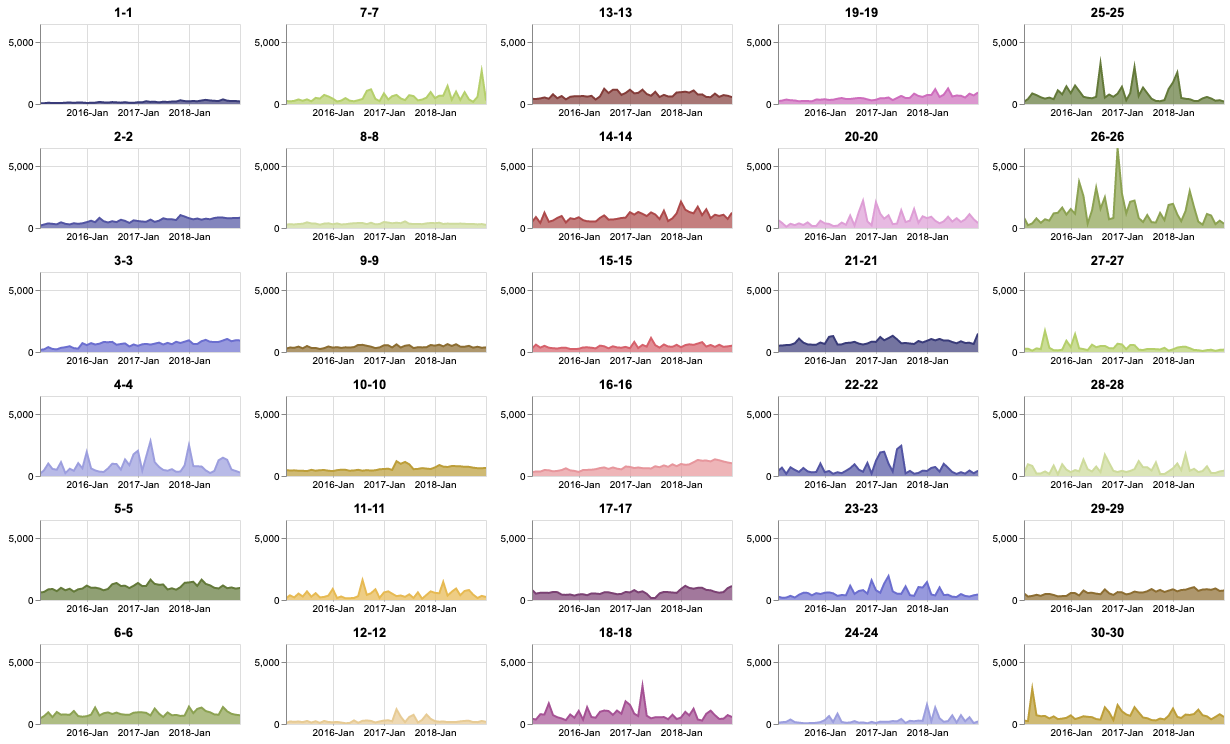

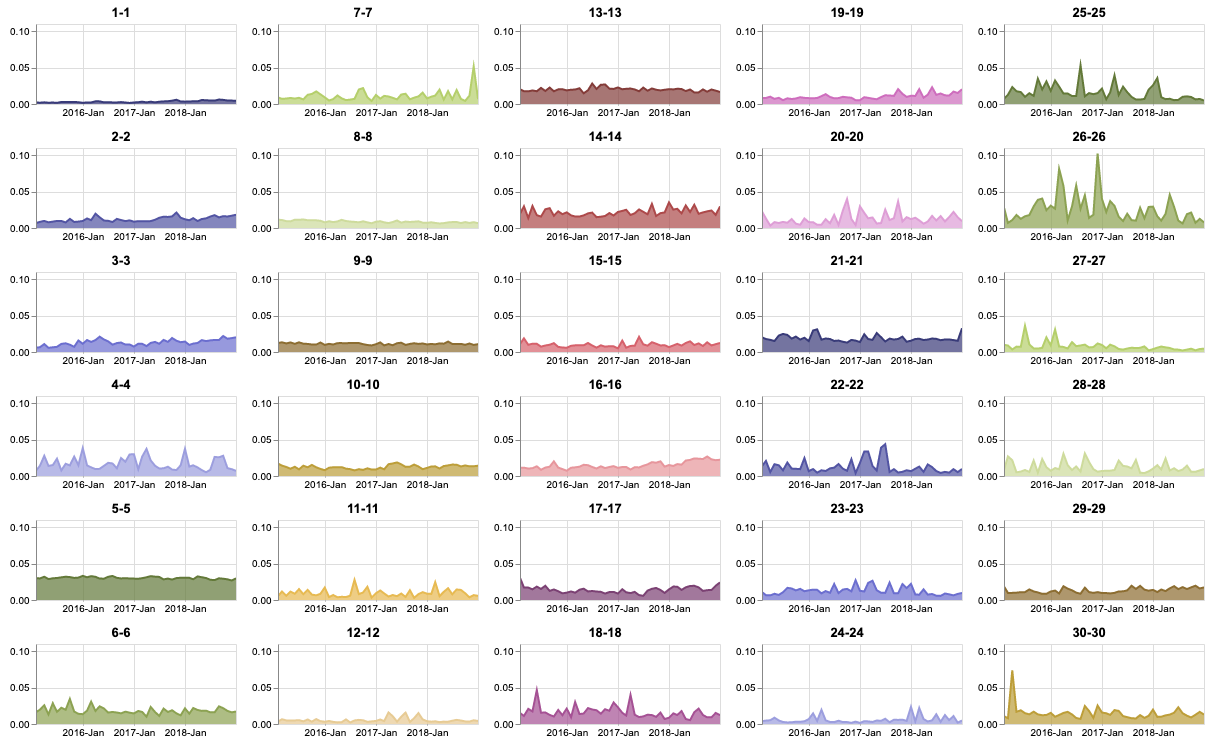

In [14]:
# temporal graph for count ###

freq='M' # 'D' 'W' 'M'
type_graph=['Count', 'Proportion']

width=200
height=80


for df_name in ['Count', 'Proportion']:
    chart=temporal_chart(db['{}-{}'.format(df_name, freq)], df_name)
    path_to_file='{}{}_graph_6_temporal_{}_{}.png'.format(c.directory['save'], 
                                                        c.project_name,
                                                        df_name,
                                                        freq
                                                    )
    chart.save(path_to_file)
#     chart.display()
    display(Image(filename=path_to_file))

# Trending Analysis

In [15]:
### calculating trend of topics ###

freq='W' # 'D' 'W' 'M'

def cox_stuart_test(df):
    
    df=pd.Series(df).fillna(value=0).to_list()
    if df[-1]==0: 
        df=df[:-1]

    if len(df)%2!=0:
        del df[len(df)//2]
    left=df[:len(df)//2]
    right=df[len(df)//2:]
    diff=[left[i]-right[i] for i in range(len(right))]
    counter_pos=0
    counter_neg=0

    for i, n in enumerate(diff):
        if n>0:
            counter_pos+=1
        elif n<0:
            counter_neg +=1
    p_val=binom.cdf(np.min([counter_pos, counter_neg]), counter_pos+counter_neg, 0.5)

    trend_diff=-np.sum(diff)/len(diff)

    return p_val<0.05, trend_diff, p_val

def calculate_trending_test(df, category):
    df.reset_index(drop=True, inplace=True)
    result=[]
    for i in range(c.num_topics):
        result.append(cox_stuart_test(list(df.loc[df['Topic']==i, category])))
    result=pd.DataFrame(result, columns=['test', '% diff', 'p-value'])
#     display_df(result)
    result_sorted=pd.concat([pd.DataFrame([c.topic_labels[int(x)] for x in list(result.index)], 
                                              columns=['Topic']),
                               result
                              ],
                              axis=1)
    result_sorted.sort_values(['test', '% diff'], inplace=True, ascending=False)
    return result_sorted

df_result=pd.DataFrame()
for df_name in ['Count', 'Proportion']:
    df=calculate_trending_test(db['{}-{}'.format(df_name, freq)], df_name)
    df['type']=df_name
    df.reset_index(inplace=True)    
    df_result=pd.concat([df_result, df], axis=1)
df_result.to_csv('{}{}_10_trend_analysis_{}.csv'.format(c.directory['save'], 
                                                        c.project_name,
                                                        freq
                                                       ),
                 index=False)
util.display_df(df_result)

,index,Topic,test,% diff,p-value,type,index,Topic,test,% diff,p-value,type
0,54,55,True,217.485714,6.032716e-22,Count,54,55,True,0.013471,1.638246e-14,Proportion
1,39,40,True,163.790476,5.479930e-05,Count,57,58,True,0.008992,2.465190e-32,Proportion
2,56,57,True,127.704762,8.362970e-13,Count,43,44,True,0.007369,8.089766e-10,Proportion
3,53,54,True,116.904762,1.104716e-03,Count,35,36,True,0.006793,5.041505e-11,Proportion
4,43,44,True,115.714286,4.758458e-27,Count,49,50,True,0.006599,1.151877e-11,Proportion
5,35,36,True,113.276190,2.613102e-30,Count,50,51,True,0.006422,2.661008e-15,Proportion
6,49,50,True,110.619048,4.758458e-27,Count,39,40,True,0.006089,3.924251e-02,Proportion
7,15,16,True,100.485714,1.226002e-25,Count,15,16,True,0.005847,2.978251e-09,Proportion
8,57,58,True,95.942857,8.488738e-18,Count,56,57,True,0.005449,8.917861e-05,Proportion
9,34,35,True,94.809524,4.107263e-04,Count,13,14,True,0.005054,1.953500e-04,Proportion


/Users/habib/anaconda2/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


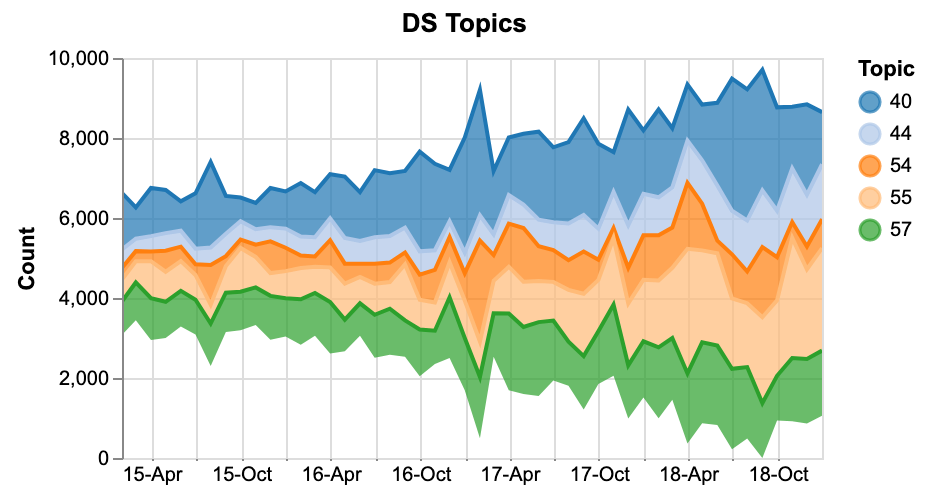

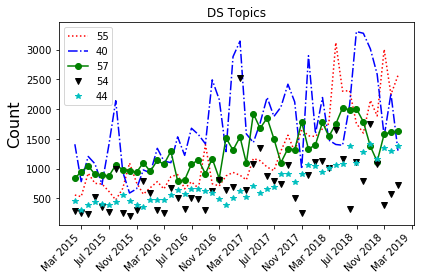

/Users/habib/anaconda2/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


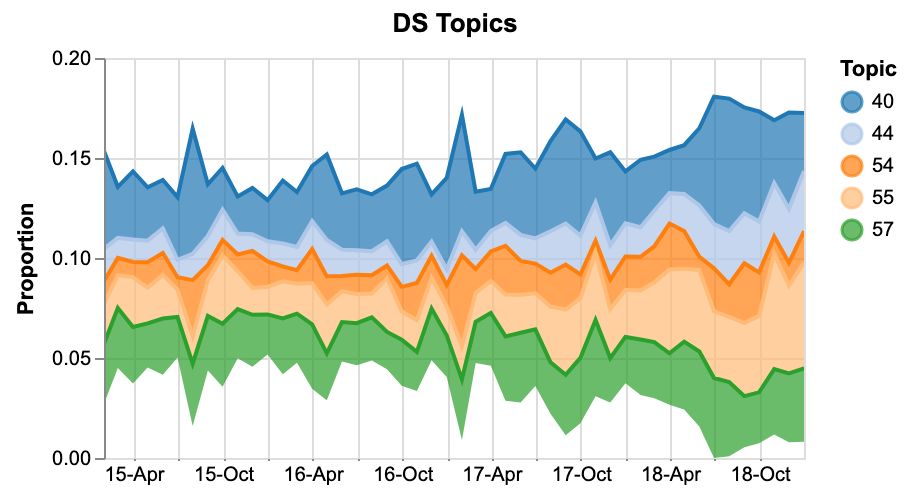

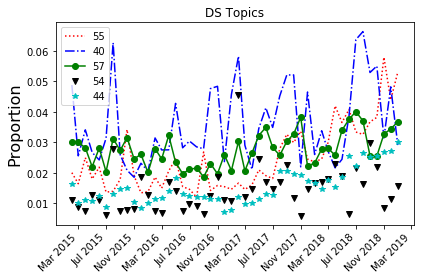

In [16]:
### plotting increasing/decreasing trends ###

freq = 'M'   # 'D' 'W' 'M'
height=200
width=350
interval = 4
graph_title='DS Topics'

graph_type='increasing'  # decreasing
trending_topics={
    54: 'r:', 
    39: 'b-.', 
    56: 'go-',
    53: 'kv',
    43: 'c*',    
}

# graph_type='decreasing'  # decreasing
# trending_topics={
#     48: 'r:', 
#     50: 'b-.', 
#     11: 'go-',
# #     12: 'kv',
# #     3: 'c*',    
# }


# colors =
# ‘b’	blue
# ‘g’	green
# ‘r’	red
# ‘c’	cyan
# ‘m’	magenta
# ‘y’	yellow
# ‘k’	black
# ‘w’	white

# lineStyles = {
# '-'	solid line style
# '--'	dashed line style
# '-.'	dash-dot line style
# ':'	dotted line style
# '.'	point marker
# ','	pixel marker
# 'o'	circle marker
# 'v'	triangle_down marker
# '^'	triangle_up marker
# '<'	triangle_left marker
# '>'	triangle_right marker
# '1'	tri_down marker
# '2'	tri_up marker
# '3'	tri_left marker
# '4'	tri_right marker
# 's'	square marker
# 'p'	pentagon marker
# '*'	star marker
# 'h'	hexagon1 marker
# 'H'	hexagon2 marker
# '+'	plus marker
# 'x'	x marker
# 'D'	diamond marker
# 'd'	thin_diamond marker
# '|'	vline marker
# '_'	hline marker


register_matplotlib_converters() 

def trending_chart(df, df_name, topics, title, graph_type):
#     df_name='Count'
#     df=dfs_trend[df_name]
    min_date= min_date_val if c.zoom_date_on_default_dates else np.min(df['Date'])
    max_date= max_date_val if c.zoom_date_on_default_dates else np.max(df['Date'])


    topics=list(topics.keys())
    index=(df['Topic']==topics[0])

    for topic in topics[1:]:
        index |= (df['Topic']==topic)

    graph_data=df[index]
    graph_data.reset_index(inplace=True)
    for topic in topics:
        graph_data.loc[graph_data.loc[:,'Topic']==topic, 'Topic']='{}'.format(c.topic_labels[topic])

#     display_df(graph_data)
    chart = alt.Chart(graph_data).mark_area(
        # ‘linear’, ‘linear-closed’, ‘step’, ‘step-before’, ‘step-after’, ‘basis’, ‘basis-open’, 
        # ‘basis-closed’, ‘cardinal’, ‘cardinal-open’, ‘cardinal-closed’, ‘bundle’, ‘monotone’ 
        interpolate='linear',
        line=True
    ).encode(
        x=alt.X("Date:T",
    #           timeUnit='yearmonthweek',
              axis=alt.Axis(format='%y-%b', domain=False, tickSize=1, title=''),
              scale=alt.Scale(domain=list(pd.to_datetime([min_date, max_date]).astype(int) / 10 ** 6))
             ),
        y=alt.Y('{}:Q'.format(df_name), 
                  stack='center', # stack='center'    stack='normalize' or None
                  axis=alt.Axis(title=df_name),
                 ),
        color=alt.Color('Topic:N',
                          scale=alt.Scale(scheme='category20'))
    ).properties(title=title, height=height, width=width).interactive()
    path_to_file='{}{}_graph_8_comparison_altair_{}_{}_{}.png'.format(c.directory['save'], 
                                                                    c.project_name,
                                                                    df_name, 
                                                                    graph_type, 
                                                                    title
                                                                   )
    chart.save(path_to_file, scale_factor=2.0)    
    return path_to_file

def trending_chart_matplot(df, df_name, topics, title, graph_type):
#     df_name='Count'
#     df=dfs_trend[df_name]
    fig, ax = plt.subplots()
    #loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    #loc = mdates.AutoDateLocator()
    #ax.xaxis.set_major_locator(loc)
    # ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(1, 32)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    # ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.xaxis.set_major_locator(plticker.MultipleLocator(base=10.0)) 
    if freq == 'M':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    elif freq == 'W':
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interval))
    elif freq == 'D':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.set_ylabel(df_name,
                  fontsize=16)        
    # ax.xaxis.set_minor_locator(mdates.DayLocator(interval = 12))

    for i, mode in topics.items():
    #     print(i)
        d=pd.Series(list(df.loc[df['Topic']==i, df_name]), 
                      index=list(df.loc[df['Topic']==i,'Date']))
        ax.plot(d, mode, label=c.topic_labels[i])

    # rt_legend, = ax.plot(date, rt_count, 'b--', label='retweet')
    # fav_legend, = ax.plot(date, fav_count, 'g-.', label='favorite')
    
    legend_loc='upper left' if graph_type=='increasing' else 'upper right'
    lgnd = plt.legend(loc=legend_loc, scatterpoints=1, fontsize=10)
    # lgnd.legendHandles[0]._sizes = [30]
    # lgnd.legendHandles[1]._sizes = [30]

    # ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    # plt.gcf().autofmt_xdate()
    # plt.gcf().autofmt_ydate()
    plt.title(title)
    fig.tight_layout()
    plt.savefig('{}{}_graph_9_comparison_plt_{}_{}_{}.png'.format(c.directory['save'], 
                                                                        c.project_name,
                                                                        df_name, 
                                                                        graph_type, 
                                                                        title),
                  bbox_inches='tight')    
    return plt

for df_name in ['Count', 'Proportion']:
    path_to_file=trending_chart(db['{}-{}'.format(df_name, freq)], df_name, trending_topics, graph_title, graph_type)
    display(Image(filename=path_to_file))
    trending_chart_matplot(db['{}-{}'.format(df_name, freq)], df_name, trending_topics, graph_title, graph_type).show()